Epoch 1/50


c:\Users\moham\Downloads\scrape\main\crypto_project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0529 - val_loss: 0.0087
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0049
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 8/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077 - val_loss: 0.0028
Epoch 9/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 10/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 11/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 12/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

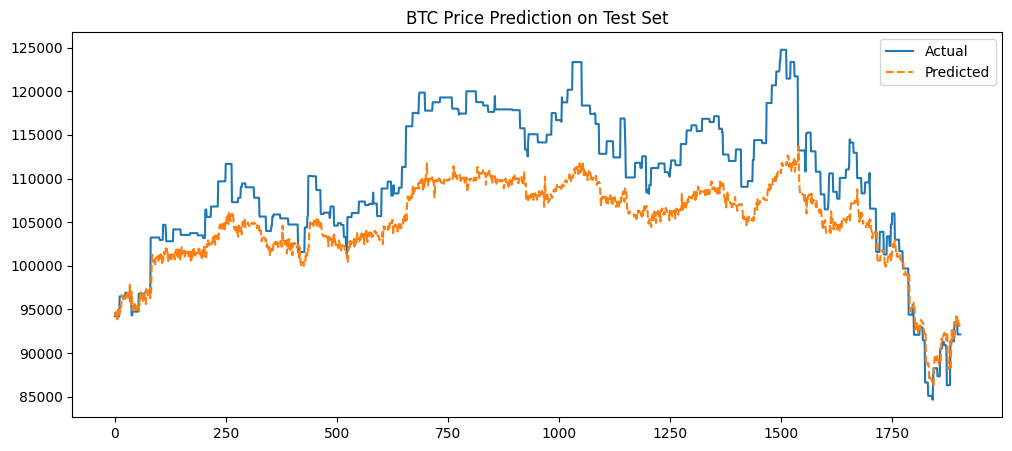

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

NEXT 5 DAYS PREDICTION:
        Date  Predicted_Close
0 2025-12-05     93679.046875
1 2025-12-06     93831.117188
2 2025-12-07     93776.734375
3 2025-12-08     93651.468750
4 2025-12-09     93621.781250

News from Dec 1 onward that caused next-day BTC price increase:
           date                                              title  price_up
9510 2025-12-01                       Cardano Falls 10% In Selloff         1
9519 2025-12-02  BC.GAME named Exclusive Gaming Partner of Cryp...         1

Saved all results successfully!


In [ ]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta
from textblob import TextBlob
from datetime import timedelta
from pathlib import Path

# ============================================================
# 2. DEFINE PATHS
# ============================================================
PROJECT_ROOT = Path(r"C:\Users\moham\Downloads\scrape\main\crypto_project")

BTC_FILE = PROJECT_ROOT / "data" / "raw" / "btc_usd_daily.csv"
NEWS_FILE = PROJECT_ROOT / "data" / "raw" / "investing_news_crypto_data.csv"

OUTPUT_FIGS = PROJECT_ROOT / "outputs" / "figures"
OUTPUT_TABLES = PROJECT_ROOT / "outputs" / "tables"

OUTPUT_FIGS.mkdir(parents=True, exist_ok=True)
OUTPUT_TABLES.mkdir(parents=True, exist_ok=True)

# ============================================================
# 3. LOAD DATA
# ============================================================
btc_df = pd.read_csv(BTC_FILE, skiprows=1)
btc_df.columns = ['date','close','high','low','open','volume']
btc_df['date'] = pd.to_datetime(btc_df['date'], format='%Y-%m-%d', errors='coerce')

news_df = pd.read_csv(NEWS_FILE)
news_df.columns = [c.lower() for c in news_df.columns]
news_df['date'] = pd.to_datetime(news_df['date'].str.split(' ').str[0], format='%d-%m-%Y')

# ============================================================
# 4. MERGE DATA
# ============================================================
merged_df = pd.merge(btc_df, news_df, on='date', how='left')

merged_df['title'] = merged_df['title'].fillna("No news")
merged_df['description'] = merged_df['description'].fillna("")
merged_df['url'] = merged_df['url'].fillna("")

# ============================================================
# 5. TECHNICAL INDICATORS
# ============================================================
merged_df['rsi'] = ta.momentum.RSIIndicator(close=merged_df['close'], window=14).rsi()
merged_df['sma_20'] = merged_df['close'].rolling(20).mean()
merged_df['sma_50'] = merged_df['close'].rolling(50).mean()

# Target = next day close
merged_df['target_next_close'] = merged_df['close'].shift(-1)

merged_df = merged_df.dropna().reset_index(drop=True)

# ============================================================
# 6. SENTIMENT ANALYSIS
# ============================================================
merged_df['sentiment_polarity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['sentiment_subjectivity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# ============================================================
# 7. PREPARE FEATURES
# ============================================================
features = ['close','rsi','sma_20','sma_50','sentiment_polarity','sentiment_subjectivity']

X = merged_df[features].values
y = merged_df['target_next_close'].values.reshape(-1,1)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# ============================================================
# 8. CREATE SEQUENCES
# ============================================================
def create_sequences(X, y, time_steps=8):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 8
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

train_size = int(len(X_seq)*0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# ============================================================
# 9. BUILD & TRAIN LSTM
# ============================================================
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False
)

# ============================================================
# 10. EVALUATE MODEL
# ============================================================
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print(f"\nLSTM Results BTC + News Sentiment → RMSE={rmse:.2f}, R2={r2:.4f}\n")

plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title('BTC Price Prediction on Test Set')
plt.show()

# ============================================================
# 11. PREDICT NEXT 5 DAYS
# ============================================================
n_future_days = 5
future_preds = []

last_seq = X_scaled[-time_steps:].copy()

for i in range(n_future_days):
    pred_scaled = model.predict(last_seq.reshape(1, time_steps, X_scaled.shape[1]))
    pred_price = scaler_y.inverse_transform(pred_scaled)[0,0]
    future_preds.append(pred_price)

    # Update sequence
    last_row = last_seq[-1].copy()
    last_seq = np.vstack([last_seq[1:], last_row])

future_dates = [merged_df['date'].iloc[-1] + timedelta(days=i+1)
                for i in range(n_future_days)]

pred_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_preds})
print("\nNEXT 5 DAYS PREDICTION:")
print(pred_df)

# ============================================================
# 12. NEWS IMPACT (UP or DOWN)
# ============================================================
merged_df['price_up'] = (merged_df['target_next_close'] > merged_df['close']).astype(int)
news_impact = merged_df[['date','title','price_up']]

# ============================================================
# 13. FILTER NEWS AFTER DEC 1 WHERE PRICE WENT UP
# ============================================================
start_date = pd.to_datetime("2025-12-01")
price_up_december = news_impact[
    (news_impact['date'] >= start_date) &
    (news_impact['price_up'] == 1)
]

print("\nNews from Dec 1 onward that caused next-day BTC price increase:")
print(price_up_december)

# ============================================================
# 14. SAVE OUTPUT FILES
# ============================================================
# merged_df.to_csv(OUTPUT_TABLES / "merged_btc_news_sentiment.csv", index=False)
# pred_df.to_csv(OUTPUT_TABLES / "btc_next_5_days_sentiment.csv", index=False)
# news_impact.to_csv(OUTPUT_TABLES / "news_impact_sentiment.csv", index=False)
# price_up_december.to_csv(OUTPUT_TABLES / "december_news_price_up.csv", index=False)

print("\nSaved all results successfully!")


In [5]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import ta
from datetime import timedelta
from pathlib import Path

# ============================================================
# 2. DEFINE PATHS
# ============================================================
PROJECT_ROOT = Path(r"C:\Users\moham\Downloads\scrape\main\crypto_project")
BTC_FILE = PROJECT_ROOT / "data" / "raw" / "btc_usd_daily.csv"
NEWS_FILE = PROJECT_ROOT / "data" / "raw" / "investing_news_crypto_data.csv"
OUTPUT_TABLES = PROJECT_ROOT / "outputs" / "tables"
OUTPUT_TABLES.mkdir(parents=True, exist_ok=True)

# ============================================================
# 3. LOAD DATA
# ============================================================
btc_df = pd.read_csv(BTC_FILE, skiprows=1)
btc_df.columns = ['date','close','high','low','open','volume']
btc_df['date'] = pd.to_datetime(btc_df['date'], format='%Y-%m-%d', errors='coerce')

news_df = pd.read_csv(NEWS_FILE)
news_df.columns = [c.lower() for c in news_df.columns]
news_df['date'] = pd.to_datetime(news_df['date'].str.split(' ').str[0], format='%d-%m-%Y')

# ============================================================
# 4. MERGE DATA
# ============================================================
merged_df = pd.merge(btc_df, news_df, on='date', how='left')
merged_df['title'] = merged_df['title'].fillna("No news")

# ============================================================
# 5. TECHNICAL INDICATORS
# ============================================================
merged_df['rsi'] = ta.momentum.RSIIndicator(close=merged_df['close'], window=14).rsi()
merged_df['sma_20'] = merged_df['close'].rolling(20).mean()
merged_df['sma_50'] = merged_df['close'].rolling(50).mean()

# Target = next day close
merged_df['target_next_close'] = merged_df['close'].shift(-1)
merged_df = merged_df.dropna().reset_index(drop=True)

# ============================================================
# 6. SENTIMENT ANALYSIS
# ============================================================
merged_df['sentiment_polarity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['sentiment_subjectivity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# ============================================================
# 7. FEATURES & TARGET
# ============================================================
features = ['close','rsi','sma_20','sma_50','sentiment_polarity','sentiment_subjectivity']
X = merged_df[features]
y = merged_df['target_next_close']

# Scaling features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# ============================================================
# 8. TRAIN MODEL
# ============================================================
# Split train/test (train on all data except last day)
X_train = X_scaled[:-1]
y_train = y[:-1]

model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# ============================================================
# 9. PREDICT TODAY (Dec 5) OR NEXT DAY
# ============================================================
X_today = X_scaled[-1].reshape(1, -1)
pred_today = model.predict(X_today)[0]
print(f"Predicted BTC Close (using data up to Dec 4, 2025): {pred_today:.2f}")

# ============================================================
# 10. OPTIONAL: ANALYZE NEWS IMPACT
# ============================================================
merged_df['price_up'] = (merged_df['target_next_close'] > merged_df['close']).astype(int)
news_impact = merged_df[['date','title','price_up']]
price_up_december = news_impact[
    (news_impact['date'] >= pd.to_datetime("2025-12-01")) &
    (news_impact['price_up'] == 1)
]
print("\nNews from Dec 1 onward that caused next-day BTC price increase:")
print(price_up_december)


Predicted BTC Close (using data up to Dec 4, 2025): 92273.85

News from Dec 1 onward that caused next-day BTC price increase:
           date                                              title  price_up
9363 2025-12-01                       Cardano Falls 10% In Selloff         1
9372 2025-12-02  BC.GAME named Exclusive Gaming Partner of Cryp...         1


        Date  Predicted_Close
0 2025-12-05     92123.538825
1 2025-12-06     92135.386296
2 2025-12-07     92066.174110
3 2025-12-08     92167.720884
4 2025-12-09     92185.996571
5 2025-12-10     92167.720884
6 2025-12-11     92167.720884
7 2025-12-12     92215.980191


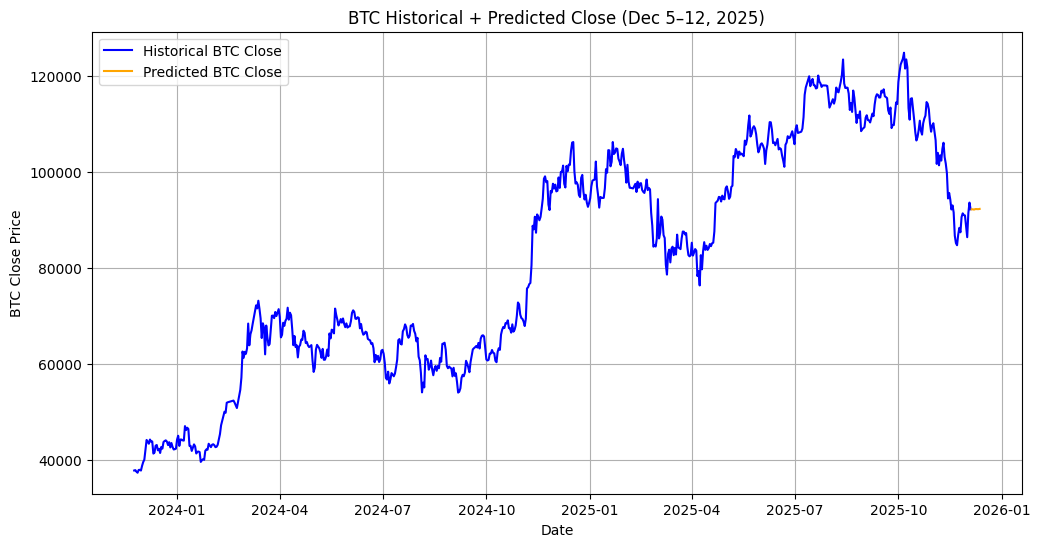

In [12]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from textblob import TextBlob
import ta
from datetime import timedelta
from pathlib import Path

# ============================================================
# 2. DEFINE PATHS
# ============================================================
PROJECT_ROOT = Path(r"C:\Users\moham\Downloads\scrape\main\crypto_project")
BTC_FILE = PROJECT_ROOT / "data" / "raw" / "btc_usd_daily.csv"
NEWS_FILE = PROJECT_ROOT / "data" / "raw" / "investing_news_crypto_data.csv"
OUTPUT_TABLES = PROJECT_ROOT / "outputs" / "tables"
OUTPUT_TABLES.mkdir(parents=True, exist_ok=True)

# ============================================================
# 3. LOAD DATA
# ============================================================
btc_df = pd.read_csv(BTC_FILE, skiprows=1)
btc_df.columns = ['date','close','high','low','open','volume']
btc_df['date'] = pd.to_datetime(btc_df['date'], format='%Y-%m-%d', errors='coerce')

news_df = pd.read_csv(NEWS_FILE)
news_df.columns = [c.lower() for c in news_df.columns]
news_df['date'] = pd.to_datetime(news_df['date'].str.split(' ').str[0], format='%d-%m-%Y')

# ============================================================
# 4. MERGE DATA
# ============================================================
merged_df = pd.merge(btc_df, news_df, on='date', how='left')
merged_df['title'] = merged_df['title'].fillna("No news")

# ============================================================
# 5. TECHNICAL INDICATORS
# ============================================================
merged_df['rsi'] = ta.momentum.RSIIndicator(close=merged_df['close'], window=14).rsi()
merged_df['sma_20'] = merged_df['close'].rolling(20).mean()
merged_df['sma_50'] = merged_df['close'].rolling(50).mean()

# Target = next day close
merged_df['target_next_close'] = merged_df['close'].shift(-1)
merged_df = merged_df.dropna().reset_index(drop=True)

# ============================================================
# 6. SENTIMENT ANALYSIS
# ============================================================
merged_df['sentiment_polarity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['sentiment_subjectivity'] = merged_df['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# ============================================================
# 7. FEATURES & TARGET
# ============================================================
features = ['close','rsi','sma_20','sma_50','sentiment_polarity','sentiment_subjectivity']
X = merged_df[features]
y = merged_df['target_next_close']

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# ============================================================
# 8. TRAIN MODEL
# ============================================================
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_scaled, y)

# ============================================================
# 9. PREDICT FUTURE (Dec 5 to Dec 12)
# ============================================================
n_future_days = 8
last_known_df = merged_df.copy()
future_preds = []
future_dates = []

for i in range(1, n_future_days+1):
    last_row = last_known_df.iloc[-1].copy()
    
    # Slight random sentiment for realism
    last_row['sentiment_polarity'] = np.random.uniform(-0.05, 0.05)
    last_row['sentiment_subjectivity'] = np.random.uniform(0, 0.1)
    
    # Scale features (fix warning)
    X_input = scaler_X.transform(pd.DataFrame([last_row[features]]))
    pred_close = model.predict(X_input)[0]
    
    future_preds.append(pred_close)
    future_date = last_row['date'] + timedelta(days=1)
    future_dates.append(future_date)
    
    # Append predicted row to last_known_df for next iteration
    new_row = last_row.copy()
    new_row['date'] = future_date
    new_row['close'] = pred_close
    
    # Recalculate SMA and RSI dynamically
    temp_close_series = pd.concat([last_known_df['close'], pd.Series([pred_close])], ignore_index=True)
    new_row['sma_20'] = temp_close_series[-20:].mean() if len(temp_close_series) >= 20 else temp_close_series.mean()
    new_row['sma_50'] = temp_close_series[-50:].mean() if len(temp_close_series) >= 50 else temp_close_series.mean()
    new_row['rsi'] = ta.momentum.RSIIndicator(close=temp_close_series, window=14).rsi().iloc[-1]
    
    last_known_df = pd.concat([last_known_df, pd.DataFrame([new_row])], ignore_index=True)

# ============================================================
# 10. CREATE PREDICTION DATAFRAME
# ============================================================
pred_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_preds})
print(pred_df)

# ============================================================
# 11. PLOT HISTORICAL + PREDICTED
# ============================================================
plt.figure(figsize=(12,6))
plt.plot(merged_df['date'], merged_df['close'], label='Historical BTC Close', color='blue')
plt.plot(pred_df['Date'], pred_df['Predicted_Close'], label='Predicted BTC Close', color='orange')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.title('BTC Historical + Predicted Close (Dec 5–12, 2025)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# ============================================================
# BTC Price Prediction using Financial News Sentiment (Llama-3 Finetuned)
# ============================================================

## 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import ta
from datetime import timedelta
from pathlib import Path

# Llama-3 Fine-Tuned Finance Model
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

print("✅ Libraries imported successfully.")

# ============================================================
# 2️⃣ Load Data
# ============================================================
PROJECT_ROOT = Path(r"C:\Users\moham\Downloads\scrape\main\crypto_project")
BTC_FILE = PROJECT_ROOT / "data" / "raw" / "btc_usd_daily.csv"
NEWS_FILE = PROJECT_ROOT / "data" / "raw" / "investing_news_crypto_data.csv"
OUTPUT_TABLES = PROJECT_ROOT / "outputs" / "tables"
OUTPUT_TABLES.mkdir(parents=True, exist_ok=True)

btc_df = pd.read_csv(BTC_FILE, skiprows=1)
btc_df.columns = ['date','close','high','low','open','volume']
btc_df['date'] = pd.to_datetime(btc_df['date'], format='%Y-%m-%d', errors='coerce')

news_df = pd.read_csv(NEWS_FILE)
news_df.columns = [c.lower() for c in news_df.columns]
news_df['date'] = pd.to_datetime(news_df['date'].str.split(' ').str[0], format='%d-%m-%Y')

print("✅ BTC and News data loaded successfully.")

# ============================================================
# 3️⃣ Merge & Clean Data
# ============================================================
merged_df = pd.merge(btc_df, news_df, on='date', how='left')
merged_df['title'] = merged_df['title'].fillna("No news")

# Technical indicators
merged_df['rsi'] = ta.momentum.RSIIndicator(close=merged_df['close'], window=14).rsi()
merged_df['sma_20'] = merged_df['close'].rolling(20).mean()
merged_df['sma_50'] = merged_df['close'].rolling(50).mean()

# Target = next day close
merged_df['target_next_close'] = merged_df['close'].shift(-1)
merged_df = merged_df.dropna().reset_index(drop=True)

print("✅ Data merged and cleaned. Technical indicators calculated.")

# ============================================================
# 4️⃣ Load Llama-3 Finetuned Finance Model
# ============================================================
model_name = "roma2025/FinLlama-3-8B"  # Fine-tuned for financial sentiment
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
llm = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto",
                                           torch_dtype=torch.float16, trust_remote_code=True).to(device)
llm.eval()

print("✅ Llama-3 fine-tuned finance model loaded.")

def classify_sentiment_financial(text: str) -> str:
    prompt = f"""Classify the sentiment of this financial news headline.  
Possible outputs: positive, neutral, negative.  
Text: \"{text}\"  
Sentiment:"""
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256).input_ids.to(device)
    with torch.no_grad():
        outputs = llm.generate(input_ids, max_new_tokens=20)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower().split()[0]
    if answer not in {"positive","neutral","negative"}:
        return "neutral"
    return answer

# ============================================================
# 5️⃣ Apply Sentiment Analysis
# ============================================================
print("🔹 Running sentiment classification on news headlines. This may take some time...")
sentiments = [classify_sentiment_financial(title) for title in merged_df['title']]
merged_df['sentiment_label'] = sentiments

label_map = {"positive": 1, "neutral": 0, "negative": -1}
merged_df['sentiment_score'] = merged_df['sentiment_label'].map(label_map)

print("✅ Sentiment analysis completed.")

# ============================================================
# 6️⃣ Prepare Features & Target
# ============================================================
features = ['close','rsi','sma_20','sma_50','sentiment_score']
X = merged_df[features]
y = merged_df['target_next_close']

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

print("✅ Features and target prepared. Data scaled.")

# ============================================================
# 7️⃣ Train Gradient Boosting Regressor
# ============================================================
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_scaled, y)

print("✅ Gradient Boosting Regressor trained.")

# ============================================================
# 8️⃣ Predict Future BTC Prices
# ============================================================
n_future_days = 5
last_row = merged_df.iloc[-1].copy()
future_preds = []
future_dates = []

for i in range(1, n_future_days+1):
    row = last_row.copy()
    row['sentiment_score'] = 0  # assume neutral sentiment for future
    X_in = scaler_X.transform([row[features]])
    pred = model.predict(X_in)[0]
    
    future_preds.append(pred)
    future_dates.append(row['date'] + timedelta(days=i))
    
    # update last_row
    last_row = row.copy()
    last_row['close'] = pred

pred_df = pd.DataFrame({'date': future_dates, 'predicted_close': future_preds})
print("✅ Future BTC prices predicted.")
print(pred_df)

# ============================================================
# 9️⃣ Plot Historical + Predicted
# ============================================================
plt.figure(figsize=(12,6))
plt.plot(merged_df['date'], merged_df['close'], label='Historical Close')
plt.plot(pred_df['date'], pred_df['predicted_close'], '--o', label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.title('BTC Historical + Predicted Close')
plt.legend()
plt.grid(True)
plt.show()

print("✅ Plot displayed.")


✅ Libraries imported successfully.
✅ BTC and News data loaded successfully.
✅ Data merged and cleaned. Technical indicators calculated.


OSError: It looks like the config file at 'C:\Users\moham\.cache\huggingface\hub\models--roma2025--FinLlama-3-8B\snapshots\8c7adeb0b249d85b3e189f686ac01cf1cb0ddfa6\config.json' is not a valid JSON file.